# Aggregating Slice Results

In this report, I will explore different ways of aggregating slice classification results, in order to evaluate fibrosis presence in patient, rather than individual slices.

This notebook already uses the optimization methods tested in `3.2 - pureVsConservative`:

 - resize before augmentations 
 - pure lowest validation loss value model choice

In [1]:
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc
from scipy.ndimage import gaussian_filter
import torch.nn.functional as F
import matplotlib.pyplot as plt
import albumentations as A
from tqdm import tqdm
import pandas as pd
import numpy as np
import pickle
import random
import copy
import os
import re



# ------------ Utils ------------

from aggregateUtils import * 

# -----------  ResNet -----------

# Core library
import torch

# Essentials for development
import torch.nn as nn
from torchsummary import summary
import torchvision.models as models
from torchvision.models import ResNet18_Weights

# Data resize (ResNet uses (224,224) inputs)
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision.transforms import ToTensor

# Allows for paralell batch processing
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.io import decode_image

c:\Users\RafaelAndre\anaconda3\envs\ild\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
print(torch.cuda.is_available())          
print(torch.cuda.get_device_name(0))     

for i in range(torch.cuda.device_count()):
    print(f"Device {i}: {torch.cuda.get_device_name(i)}")

True
NVIDIA GeForce GTX 1080
Device 0: NVIDIA GeForce GTX 1080


In [3]:
# Loads the dataframe
df_fibrosis = pd.read_pickle(r'..\..\..\\fibrosis_data.pkl')

In [4]:
df_annotations = df_fibrosis.drop(columns="SliceData")
df_annotations["SliceID"] = df_annotations["SliceID"].astype(str) + ".npy" # better for data loader
df_annotations.head()

,SliceID,Class
0,101__CT-0002-0001.npy,0
1,101__CT-0002-0002.npy,0
2,101__CT-0002-0003.npy,0
3,101__CT-0002-0004.npy,0
4,101__CT-0002-0005.npy,0


In [5]:
class FibrosisDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, albumentations=None, gauss=False):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.albumentations = albumentations
        self.gauss = gauss

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # idx represents index
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])

        # Load the .npy file
        image = np.load(img_path)
        
        #image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]

        # Adds randomly selected gauss noise or blur
        if self.gauss:
            # Gaussian Noise
            gauss_noise = image + np.random.normal(loc=0, scale=random.choice(range(10,40)), size=image.shape)
            # Gaussian Blur
            gauss_blur = gaussian_filter(image, sigma=(random.choice(range(10,16))/10)) 
            # Random choice
            image = random.choice((gauss_noise,gauss_blur))

        # Guarantee compatibility
        if self.gauss or self.albumentations: image = image.astype(np.float32)

        # Applies necessary ResNet input transformations
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

All of the train-test-validation splits were previously doccumented and performed in `2 - testSplit`:

## Training

In [ ]:
def trainResNet(train_dataset, val_dataset, num_epochs=90, batch_size=32, lr=5e-7, patience=5, improve_min=0.001):
    # New ResNet instance
    resnet18 = models.resnet18(weights=ResNet18_Weights.DEFAULT)

    # Considers only absolute lowest val_loss value
    best_model_pure = copy.deepcopy(resnet18)
    best_val_pure, epoch_pure = 10, 0

    # Use only 2 output neurons
    num_ftrs = resnet18.fc.in_features
    resnet18.fc = nn.Linear(num_ftrs, 2)  

    # If graphics card is available, uses it
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    resnet18.to(device)

    print("*"+("-"*29)+"*")
    print("|{:^29}|".format(f"Using {device}"))
    print("*"+("-"*29)+"*")

    # Generate data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Loss function 
    criterion = nn.CrossEntropyLoss()  
    # ADAM
    optimizer = torch.optim.Adam(resnet18.parameters(), lr=lr)

    # add learning_rate_scheduler e step learning rate

    # Initializing early stop counter (based on validation loss)
    best_loss = 10
    early_stop_ctr = 0

    loss_array = []
    val_loss_array = []


    for epoch in range(num_epochs):
        resnet18.train()
        running_loss = 0.0
        running_val_loss = 0.0


        # --------------- Weight updates ---------------
        
        # Iterates over each image in dataset, updates weights
        for images, labels in tqdm((train_loader), desc = "Training..."):
            images, labels = images.to(device), labels.to(device)
            
            # Applies ADAM 
            optimizer.zero_grad()

            # Generates output
            outputs = resnet18(images)

            # Computes loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        # Computes average training loss
        avg_loss_train = running_loss/len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train loss: {avg_loss_train:.6f}")
        loss_array.append(avg_loss_train)


        # ---------------- Validation Loss -----------------

        # Iterates over each image in dataset, computes validation loss
        for images, labels in (val_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Applies ADAM 
            optimizer.zero_grad()

            # Generates output
            outputs = resnet18(images)

            # Computes loss
            val_loss = criterion(outputs, labels)
            
            running_val_loss += val_loss.item()

        # Computes average validation loss
        avg_loss_val = running_val_loss/len(val_loader)
        print(f"Validation loss: {avg_loss_val:.6f}")
        val_loss_array.append(avg_loss_val)


        # ------------------ Best Model -------------------

        if epoch >= 35:
            if avg_loss_val < best_val_pure:
                best_val_pure = avg_loss_val
                best_model_pure = copy.deepcopy(resnet18)
                epoch_pure = epoch
        
        
        # ---------------- Early Stopping -----------------

        # Only after a high number of epochs (around 60)
        if epoch > 60:
            # Check for improvement (1% standard)
            if abs(best_loss - avg_loss_val) > (best_loss * improve_min):
                best_loss = avg_loss_val
                early_stop_ctr = 0
            else: early_stop_ctr += 1

            # Checks early stopping condition
            if early_stop_ctr >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs!!!")
                break
    
    return best_model_pure, epoch_pure, loss_array, val_loss_array

In [7]:
# Paths
img_dir = r'..\..\..\np_ROI_data'  # CSV with image filenames & labels
annotations_file_train = r"..\trainTestCustom\train.csv"
annotations_file_test = r"..\trainTestCustom\test.csv"
annotations_file_val = r"..\trainTestCustom\val.csv"

# Transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert (1, H, W) → (3, H, W)
])

# Augmentations
augment = A.Compose([
    # Applies resize prior to augmentations
    # Could hinder scan quality, but drastically improves training speed
    A.Resize(224, 224),
    # Rotate
    A.Rotate(limit=(-350,30), p=0.8),
    # Translate
    A.Affine(translate_percent={"x":(-0.15,0.15), "y":{-0.23,0.25}},
              rotate=0, scale=1, p=0.8),
    # Shear
    A.Affine(shear={"x":(-15,15), "y":(-15,15)},p=0.8)
])

# Randomized Gaussian Noise and Blur
gauss = True

# Create Datasets
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform, albumentations=augment, gauss=gauss)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)
val_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)

In [ ]:
class ResNetFeat(ResNet):
    def _forward_impl_feat(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        return x
    
models_path = "..\\..\\..\\trainedResNets\\aggregateProb\\"
os.makedirs(models_path, exist_ok=True)

ans = str(input("Do you wish to run or read?"))

# Choice execution
if ans == "run": 
    resnet_eval, best_epoch, custom_loss, custom_val_loss = trainResNet(train_dataset,val_dataset)

elif ans == "read":
    # Setup ResNet for Reading
    resnet_eval = models.resnet18(weights=ResNet18_Weights.DEFAULT)
    

    # Use only 2 output neurons
    num_ftrs = resnet_eval.fc.in_features
    resnet_eval.fc = nn.Linear(num_ftrs, 2)

    # Read file
    checkpoint = torch.load(os.path.join(models_path,"resnet_aggregate.pt"))

    # Load values
    best_epoch = checkpoint["epoch"]
    custom_loss = checkpoint["train_loss"]
    custom_val_loss = checkpoint["val_loss"]

    # Load weights
    resnet_eval.load_state_dict(checkpoint['model_state_dict'])
    
else: print("Invalid answer, try again.")

In [ ]:
ans = str(input("Do you wish to save?"))

if ans == "yes": 
    torch.save({
    'epoch': best_epoch,
    'train_loss': custom_loss,
    'val_loss': custom_val_loss
}, os.path.join(models_path, 'resnet_aggregate.pt'))
    
    torch.save(resnet_eval, (f"{models_path}"+"resnet_hrct.pkl"))

else: print("DID NOT SAVE")

# Results and Aggregation Methods

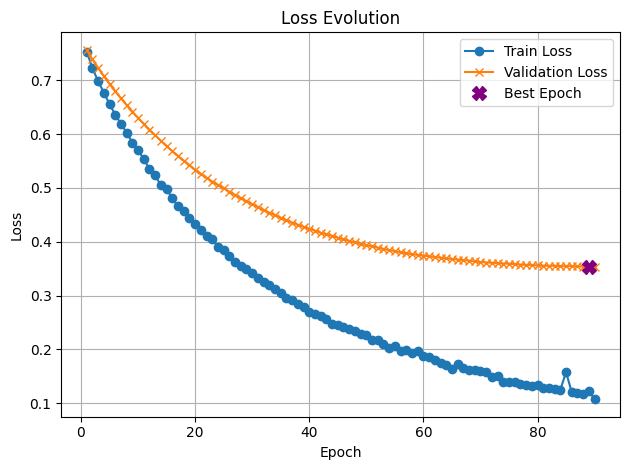

Best Validation Loss:  0.3530456679207938


In [9]:
plotLoss(custom_loss, custom_val_loss, best_epoch)
print("Best Validation Loss: ",custom_val_loss[best_epoch])

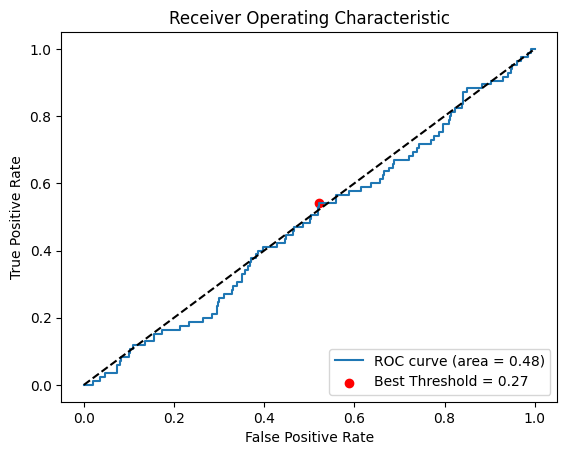

Area Under Curve: 0.4793438512172187
Best Threshold (closest to (0,1)): 0.27137405


In [10]:
threshold_eval, auc_eval = getROC(resnet_eval, val_dataset)

In [ ]:
def evalResNet(resnet18, test_dataset, threshold, auc):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Counters for each class
    correct, total = 0, 0
    correct_class_0, total_class_0 = 0, 0
    correct_class_1, total_class_1 = 0, 0

    # Needed for F1 score and confusion matrix
    y_true = []
    y_pred = []

    lat=resnet.define_hook(fc)

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Transform outputs to probabilities
            outputs = resnet18(images)

            # Translate logits to Class 1 probabilities using softmax
            probs = F.softmax(outputs, dim=1)[:, 1] 

            # Translate prob vs threshold to predictions
            # True if prob >= threshold else False
            # .long() transforms True/False to 1/0
            predicted = (probs >= threshold).long()
            
            # Update total and correct for general accuracy
            total += labels.size(0)

            correct += (predicted == labels).sum().item()

            # Class-specific accuracy
            for label, pred in zip(labels, predicted):
                if label == 0:
                    total_class_0 += 1
                    if pred == label:
                        correct_class_0 += 1
                elif label == 1:
                    total_class_1 += 1
                    if pred == label:
                        correct_class_1 += 1

            # Add data to lists
            y_true.extend(labels.cpu().tolist())
            y_pred.extend(predicted.cpu().tolist())



    # Weights == inverse proportions
    weight_0, weight_1 = 0.133, 0.867

    print("Total examples:", total)

    # -------------------------------     Perfomance Metrics     -------------------------------

    # Accuracy
    accuracy_class_0 = 100 * (correct_class_0 / total_class_0) if total_class_0 > 0 else 0
    accuracy_class_1 = 100 * (correct_class_1 / total_class_1) if total_class_1 > 0 else 0
    accuracy = 100 * (correct / total)
    accuracy2 = 100 * ((correct_class_0 + correct_class_1) / total)
    weighted_accuracy = ((accuracy_class_0*weight_0) + (accuracy_class_1*weight_1))

    # F1 scores
    f1_macro = f1_score(y_true, y_pred, average='macro') # Assigns same importance to each class
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_class_0 = f1_score(y_true, y_pred, pos_label=0)
    f1_class_1 = f1_score(y_true, y_pred, pos_label=1)

    # Confusion Matrix
    conf_mat = confusion_matrix(y_true, y_pred)


    # -------------------------------     Print Results     -------------------------------

    # Accuracy
    print("\n --------------------- \n")
    print(f"Accuracy for Class 0: {accuracy_class_0:.2f}%  ({correct_class_0} in {total_class_0})")
    print(f"Accuracy for Class 1: {accuracy_class_1:.2f}%  ({correct_class_1} in {total_class_1})")
    print(f"Test Accuracy: {accuracy:.2f}%")
    if f"{accuracy:.2f}" != f"{accuracy2:.2f}": print("ERROR CALCULATING ACCURACIES")
    print(f"Weighted Accuracy: {weighted_accuracy:.2f}%")

    # AUC
    print("\n --------------------- \n")
    print("Area Under Curve:", auc)

    # F1 scores
    print("\n --------------------- \n")
    print(f"F1 Score (Macro): {f1_macro:.3f}")
    print(f"F1 Score (Weighted): {f1_weighted:.3f}")
    print(f"F1 Score Class 0: {f1_class_0:.3f}")
    print(f"F1 Score Class 1: {f1_class_1:.3f}")

    # Confusion matrix
    print("\n --------------------- \n")
    print("\nConfusion Matrix: \n", conf_mat)

In [27]:
evalResNet(resnet_eval, test_dataset,threshold_eval,auc_eval)

Total examples: 648

 --------------------- 

Accuracy for Class 0: 72.65%  (409 in 563)
Accuracy for Class 1: 71.76%  (61 in 85)
Test Accuracy: 72.53%
Weighted Accuracy: 71.88%

 --------------------- 

Area Under Curve: 0.7763661059450424

 --------------------- 

F1 Score (Macro): 0.614
F1 Score (Weighted): 0.767
F1 Score Class 0: 0.821
F1 Score Class 1: 0.407

 --------------------- 


Confusion Matrix: 
 [[409 154]
 [ 24  61]]


## Patient-wise Classification

This will be done through aggregation of the probabilities determined by the resnet for each slice.

My plan is to create:
 - a dictionary containing keys as "PatientID" and values as arrays of probabilities. 
 - another dictionary containing the same keys, but with binary classification value arrays.

In [ ]:
def getPatientID(s):
    # HRCT_Pilot__PatientID
    match = re.search(r'HRCT_Pilot__(\d+)__', s)
    if match: return match.group(1)
        
    # PatientID__sliceSpecific
    match = re.match(r'(\d+)__', s)
    if match:
        return match.group(1)
    return None  

In [ ]:
def evalPatientResNet(resnet18, test_dataset, threshold, auc):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Counters for each class
    correct, total = 0, 0
    correct_class_0, total_class_0 = 0, 0
    correct_class_1, total_class_1 = 0, 0

    # Needed for F1 score and confusion matrix
    y_true = []
    y_pred = []


    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Transform outputs to probabilities
            outputs = resnet18(images)

            # Translate logits to Class 1 probabilities using softmax
            probs = F.softmax(outputs, dim=1)[:, 1] 

            # Translate prob vs threshold to predictions
            # True if prob >= threshold else False
            # .long() transforms True/False to 1/0
            predicted = (probs >= threshold).long()
            
            # Update total and correct for general accuracy
            total += labels.size(0)

            correct += (predicted == labels).sum().item()

            # Class-specific accuracy
            for label, pred in zip(labels, predicted):
                if label == 0:
                    total_class_0 += 1
                    if pred == label:
                        correct_class_0 += 1
                elif label == 1:
                    total_class_1 += 1
                    if pred == label:
                        correct_class_1 += 1

            # Add data to lists
            y_true.extend(labels.cpu().tolist())
            y_pred.extend(predicted.cpu().tolist())



    # Weights == inverse proportions
    weight_0, weight_1 = 0.133, 0.867

    print("Total examples:", total)

    # -------------------------------     Perfomance Metrics     -------------------------------

    # Accuracy
    accuracy_class_0 = 100 * (correct_class_0 / total_class_0) if total_class_0 > 0 else 0
    accuracy_class_1 = 100 * (correct_class_1 / total_class_1) if total_class_1 > 0 else 0
    accuracy = 100 * (correct / total)
    accuracy2 = 100 * ((correct_class_0 + correct_class_1) / total)
    weighted_accuracy = ((accuracy_class_0*weight_0) + (accuracy_class_1*weight_1))

    # F1 scores
    f1_macro = f1_score(y_true, y_pred, average='macro') # Assigns same importance to each class
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_class_0 = f1_score(y_true, y_pred, pos_label=0)
    f1_class_1 = f1_score(y_true, y_pred, pos_label=1)

    # Confusion Matrix
    conf_mat = confusion_matrix(y_true, y_pred)


    # -------------------------------     Print Results     -------------------------------

    # Accuracy
    print("\n --------------------- \n")
    print(f"Accuracy for Class 0: {accuracy_class_0:.2f}%  ({correct_class_0} in {total_class_0})")
    print(f"Accuracy for Class 1: {accuracy_class_1:.2f}%  ({correct_class_1} in {total_class_1})")
    print(f"Test Accuracy: {accuracy:.2f}%")
    if f"{accuracy:.2f}" != f"{accuracy2:.2f}": print("ERROR CALCULATING ACCURACIES")
    print(f"Weighted Accuracy: {weighted_accuracy:.2f}%")

    # AUC
    print("\n --------------------- \n")
    print("Area Under Curve:", auc)

    # F1 scores
    print("\n --------------------- \n")
    print(f"F1 Score (Macro): {f1_macro:.3f}")
    print(f"F1 Score (Weighted): {f1_weighted:.3f}")
    print(f"F1 Score Class 0: {f1_class_0:.3f}")
    print(f"F1 Score Class 1: {f1_class_1:.3f}")

    # Confusion matrix
    print("\n --------------------- \n")
    print("\nConfusion Matrix: \n", conf_mat)